In [1]:
def modificar_geo(archivo_entrada, archivo_salida, nuevo_n, nuevo_r):
    with open(archivo_entrada, "r") as f:
        lineas = f.readlines()

    nuevas_lineas = []
    for linea in lineas:
        if linea.strip().startswith("n ="):
            nuevas_lineas.append(f"n = {nuevo_n};\n")
        elif linea.strip().startswith("r ="):
            nuevas_lineas.append(f"r = {nuevo_r};\n")
        elif "Transfinite Curve{1, 2}" in linea:
            nuevas_lineas.append(f"Transfinite Curve{{1, 2}} = {nuevo_n} Using Progression {nuevo_r};\n")
        elif "Transfinite Curve{4, 3}" in linea:
            nuevas_lineas.append(f"Transfinite Curve{{4, 3}} = {nuevo_n} Using Progression 1/{nuevo_r};\n")
        else:
            nuevas_lineas.append(linea)

    with open(archivo_salida, "w") as f:
        f.writelines(nuevas_lineas)

    print(f"Archivo guardado como '{archivo_salida}' con n = {nuevo_n} y r = {nuevo_r}")


In [2]:
modificar_geo("geo.geo", "geo.geo", nuevo_n=10, nuevo_r=1.3)

Archivo guardado como 'geo.geo' con n = 10 y r = 1.3


In [3]:
import gmsh
import meshio
from nodes import Node
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import gmsh
import meshio
from nodes import Node
from elements import LST

import gmsh
import meshio

import gmsh
import meshio
import numpy as np

import gmsh
import meshio
from nodes import Node  # Asegúrate de tener esta clase
from elements import LST    # Tu clase LST

def fixed_load_mesh_objects(geo_file="geo.geo", msh_file="mesh.msh"):
    gmsh.initialize()
    gmsh.open(geo_file)
    gmsh.option.setNumber("Mesh.ElementOrder", 2)
    gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
    gmsh.model.mesh.generate(2)
    gmsh.write(msh_file)  # ⚠️ IMPORTANTE: genera el .msh antes de leerlo
    gmsh.finalize()

    # Leer malla
    mesh = meshio.read(msh_file)

    # Crear nodos
    nodes = [Node(i + 1, x, y) for i, (x, y, _) in enumerate(mesh.points)]

    # Obtener nodos de borde con etiquetas físicas
    boundary_nodes = {}
    gmsh.initialize()
    gmsh.open(msh_file)

    physicals = gmsh.model.getPhysicalGroups(1)
    name_map = {}
    for dim, tag in physicals:
        name = gmsh.model.getPhysicalName(dim, tag)
        name_map[tag] = name
        boundary_nodes[name] = set()

        entities = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
        for entity in entities:
            _, _, node_tags = gmsh.model.mesh.getElements(dim, entity)
            for nlist in node_tags:
                for node_id in nlist:
                    boundary_nodes[name].add(int(node_id))


    gmsh.finalize()

    # Asignar etiquetas de borde a los nodos
    for node in nodes:
        node.boundary_label = []
        for name, id_set in boundary_nodes.items():
            if node.id in id_set:
                node.boundary_label.append(name)

    # Crear elementos LST
    lst_elements = []
    for cell_block in mesh.cells:
        if cell_block.type in ["triangle6", "triangle"]:
            for i, node_ids in enumerate(cell_block.data):
                if len(node_ids) == 6:
                    node_ids = [int(id) + 1 for id in node_ids]  # +1 para pasar a base 1
                    lst_elements.append(LST(i + 1, node_ids))

    print(boundary_nodes)

    return nodes, lst_elements

import numpy as np
import matplotlib.pyplot as plt

def plot_mesh(nodes, elements, show_node_ids=False, show_elem_ids=False):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    for elem in elements:
        # Coordenadas de los 6 nodos del elemento (en orden)
        coords = np.array([[nodes[nid - 1].x, nodes[nid - 1].y] for nid in elem.node_ids])

        # Lado 1-2 con nodo medio 4
        ax.plot(
            [coords[0][0], coords[3][0], coords[1][0]],
            [coords[0][1], coords[3][1], coords[1][1]],
            color='gray', linewidth=1
        )

        # Lado 2-3 con nodo medio 5
        ax.plot(
            [coords[1][0], coords[4][0], coords[2][0]],
            [coords[1][1], coords[4][1], coords[2][1]],
            color='gray', linewidth=1
        )

        # Lado 3-1 con nodo medio 6
        ax.plot(
            [coords[2][0], coords[5][0], coords[0][0]],
            [coords[2][1], coords[5][1], coords[0][1]],
            color='gray', linewidth=1
        )

    # Mostrar nodos
    if show_node_ids:
        for node in nodes:
            ax.text(node.x, node.y, str(node.id), color='blue', fontsize=7, ha='center', va='center')

    # Mostrar ID de elementos
    if show_elem_ids:
        for elem in elements:
            coords = np.array([[nodes[j - 1].x, nodes[j - 1].y] for j in elem.node_ids[:3]])
            centroid = coords.mean(axis=0)
            ax.text(*centroid, str(elem.id), color='red', fontsize=8, ha='center')

    ax.set_title("Mesh of triangular elements (LST)")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.tight_layout()
    plt.savefig("LST_mesh_plot.png", dpi=300)
    plt.show()





Info    : Reading 'geo.geo'...
Info    : Done reading 'geo.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00113163s, CPU 0.000402s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.000947917s, CPU 0.000107s)
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 30%] Meshing curve 2 order 2
Info    : [ 50%] Meshing curve 3 order 2
Info    : [ 70%] Meshing curve 4 order 2
Info    : [ 90%] Meshing surface 1 order 2
Info    : Surface mesh: worst distortion = 1 (0 elements in ]0, 0.2]); worst gamma = 0.228496
Info    : Done meshing order 2 (Wall 0.000852417s, CPU 0.000497s)
Info    : 361 nodes 202 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'

Info    : Reading 'mesh.msh'...
Info    : 361 nodes


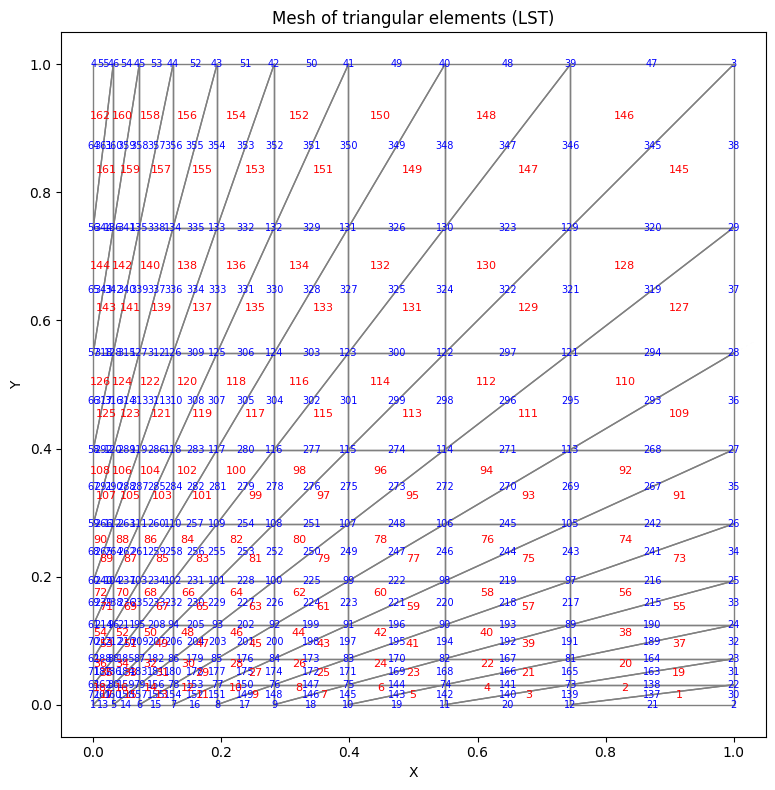

In [4]:
nodes, elements = fixed_load_mesh_objects("geo.geo", "mesh.msh")
plot_mesh(nodes, elements, show_node_ids=True, show_elem_ids=True)


In [5]:
#Ahora debo calcular la solucion u
alpha = 3

for node in nodes:
    node.solve_u(alpha)

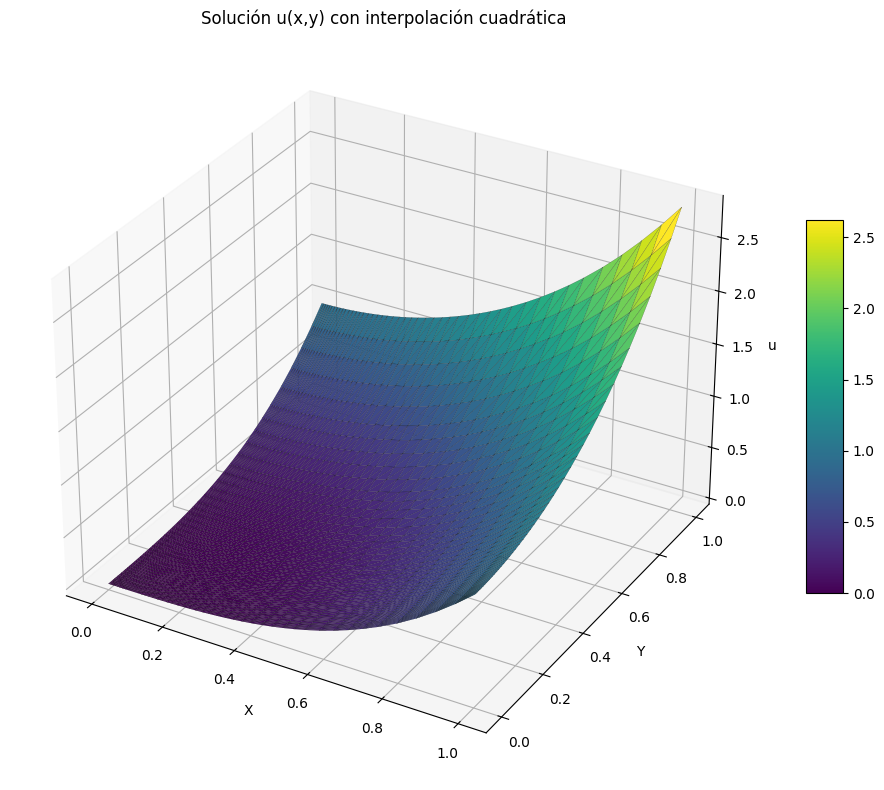

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation

def plot_u_surface_quadratic_elements(nodes, elements, use_attr="u_fem", n_sub=5):
    """
    Grafica u(x,y) como superficie suave evaluando por elemento LST con funciones cuadráticas.
    Cada triángulo se subdivide en sub-triángulos interpolados con 6 nodos.
    """

    def shape_functions_LST(xi, eta):
        L1 = 1 - xi - eta
        L2 = xi
        L3 = eta
        return np.array([
            L1 * (2 * L1 - 1),      # N1
            L2 * (2 * L2 - 1),      # N2
            L3 * (2 * L3 - 1),      # N3
            4 * L1 * L2,            # N4
            4 * L2 * L3,            # N5
            4 * L3 * L1             # N6
        ])

    # Subdivisión uniforme del triángulo de referencia
    xi_vals, eta_vals = [], []
    for i in range(n_sub + 1):
        for j in range(n_sub + 1 - i):
            xi_vals.append(i / n_sub)
            eta_vals.append(j / n_sub)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    X_all, Y_all, Z_all, tri_all = [], [], [], []
    base_idx = 0

    for elem in elements:
        if len(elem.node_ids) != 6:
            continue

        coords = np.array([[nodes[i - 1].x, nodes[i - 1].y] for i in elem.node_ids])
        u_vals = np.array([getattr(nodes[i - 1], use_attr) for i in elem.node_ids])

        local_X, local_Y, local_Z = [], [], []

        for xi, eta in zip(xi_vals, eta_vals):
            N = shape_functions_LST(xi, eta)
            xy = N @ coords
            u = N @ u_vals

            local_X.append(xy[0])
            local_Y.append(xy[1])
            local_Z.append(u)

        # Generar conectividad de sub-triangulación
        index_map = {}
        idx = 0
        for i in range(n_sub + 1):
            for j in range(n_sub + 1 - i):
                index_map[(i, j)] = base_idx + idx
                idx += 1

        for i in range(n_sub):
            for j in range(n_sub - i):
                a = index_map[(i, j)]
                b = index_map[(i + 1, j)]
                c = index_map[(i, j + 1)]
                tri_all.append([a, b, c])
                if j < n_sub - i - 1:
                    d = index_map[(i + 1, j + 1)]
                    tri_all.append([b, d, c])

        X_all.extend(local_X)
        Y_all.extend(local_Y)
        Z_all.extend(local_Z)
        base_idx += len(local_X)

    triang = Triangulation(X_all, Y_all, tri_all)
    surf = ax.plot_trisurf(triang, Z_all, cmap='viridis', edgecolor='k', linewidth=0.1)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel(use_attr)
    ax.set_title(f"Solución {use_attr}(x,y) con interpolación cuadrática")

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.savefig(f"LST_{use_attr}_sol_surface_plot.png", dpi=300)
    plt.show()

plot_u_surface_quadratic_elements(nodes, elements, use_attr="u")   


In [7]:
#Bien, ahora es nesesario ensamblar la stifnes matrix de cada elemento CST
from solve import Solve

Estructure = Solve(nodes, elements, alpha)



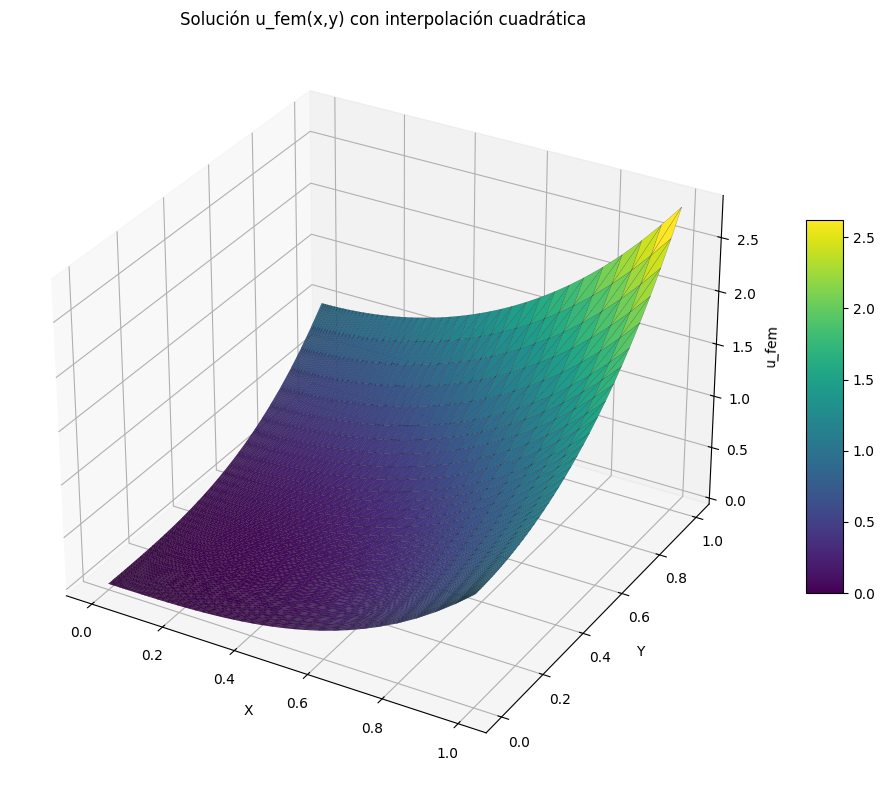

In [8]:
#Bien, ahora es nesesario calcular la solucion,
#Conozco todos lo que esta en la frontera diritchlet
Estructure.solve_matrix()
plot_u_surface_quadratic_elements(nodes, elements, use_attr="u_fem")  # solución FEM



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

def plot_relative_error_surface_3d(nodes, elements):
    """
    Grafica una superficie 3D del error relativo nodal entre u FEM y u exacto,
    usando solo los vértices de los elementos LST (primeros 3 nodos de cada uno).
    """
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    u_num = np.array([node.u_fem for node in nodes])
    u_ref = np.array([node.u for node in nodes])

    eps = 1e-14
    error_rel = np.abs(u_num - u_ref) / (np.abs(u_ref) + eps)

    # Usar solo los 3 primeros nodos (vértices) para visualización
    triangles = []
    for elem in elements:
        if len(elem.node_ids) >= 3:
            tri = [elem.node_ids[0] - 1, elem.node_ids[1] - 1, elem.node_ids[2] - 1]
            triangles.append(tri)

    triangles = np.array(triangles)
    triang = Triangulation(x, y, triangles)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(triang, error_rel, cmap='plasma', edgecolor='k', linewidth=0.2)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Relative error')
    ax.set_title('Nodal relative error between FEM u and exact u')


    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.savefig("LST_relative_error_surface_plot.png", dpi=300)
    plt.show()

    # Resumen de errores
    print(f"Máximo error relativo: {np.max(error_rel):.2e}")
    print(f"Promedio error relativo: {np.mean(error_rel):.2e}")
    print(f"Mínimo error relativo: {np.min(error_rel):.2e}")


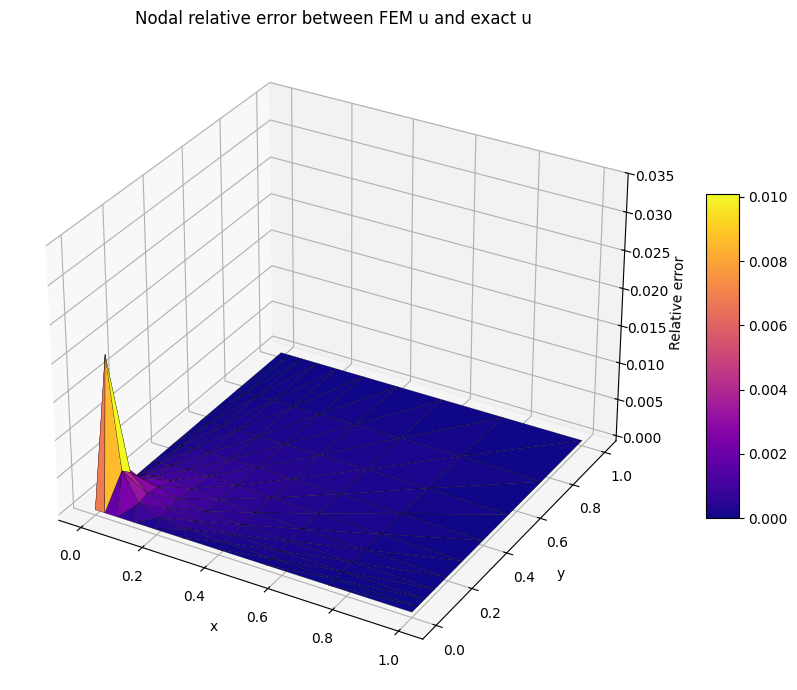

Máximo error relativo: 3.43e-02
Promedio error relativo: 4.38e-04
Mínimo error relativo: 0.00e+00


In [10]:
plot_relative_error_surface_3d(nodes, elements)


In [11]:
import numpy as np

def semi_norm_H1_0(alpha, orden=5):
    """
    Calcula |u|^2_{H^1_0(Ω)} = ∫_Ω |∇u(x,y)|² dxdy, donde u = (x² + y²)^{α/2},
    y Ω = [0,1] × [0,1] usando cuadratura de Gauss-Legendre.
    """
    puntos, pesos = np.polynomial.legendre.leggauss(orden)
    puntos = 0.5 * (puntos + 1)
    pesos = 0.5 * pesos

    total = 0.0

    for i in range(orden):
        for j in range(orden):
            x = puntos[i]
            y = puntos[j]
            w = pesos[i] * pesos[j]

            r2 = x**2 + y**2
            if r2 == 0 and alpha < 1:
                grad2 = 0.0  # evitar singularidad
            else:
                grad2 = alpha**2 * r2**(alpha - 1)

            total += grad2 * w

    return total  # ya es la semi-norma al cuadrado


result = semi_norm_H1_0(alpha, orden=5)
print(f"Resultado de |u|^2_{{H^1_0(Ω)}}: {result:.4f}")


Resultado de |u|^2_{H^1_0(Ω)}: 5.6000


In [12]:
from scipy.sparse import csr_matrix

fem_solution = Estructure.femm_solution()
print(f"Solución FEM (xᵀ K x): {fem_solution:.4f}")

Solución FEM (xᵀ K x): 5.6008
